In [1]:
from tensorflow.keras.applications.vgg16 import VGG16
# Top 부분이 포함된 모형
model = VGG16(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [2]:
# include_top = True와 비교
model1 = VGG16(weights='imagenet', include_top=False)
model1.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [3]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
# from tensorflow.keras.applications.imagenet_utils import preprocess_input
import numpy as np

In [4]:
img = Image.open('cat.jpg')
img.size

(300, 280)

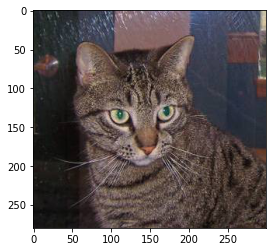

In [5]:
plt.imshow(np.asarray(img))

### Image cropping
여기서는 center cropping 방법을 사용해서 정사각형으로 만든다.<br>

300 280 10 0 280


(280, 280)

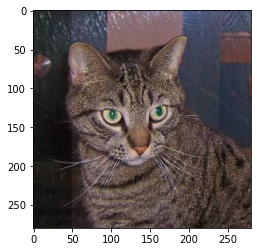

In [6]:
w, h = img.size
s = min(w, h)
y = (h - s) // 2
x = (w - s) // 2
print(w, h, x, y, s)
img = img.crop((x, y, x+s, y+s))
# 4-tuple defining the left, upper, right, and lower pixel coordinate
plt.imshow(np.asarray(img))
img.size

그 다음에 해야 하는 것은 VGG16이 입력받는 크기로 이미지를 resize (확대 또는 축소) 해주기 <br>
이를 위해 먼저 입력받는 이미지의 크기를 아래와 같이 확인

In [7]:
model.layers[0].input_shape # 224x224의 칼라이미지를 입력 받는다. 

[(None, 224, 224, 3)]

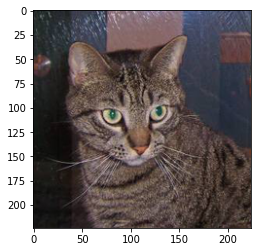

In [8]:
target_size = 224
img = img.resize((target_size, target_size)) # resize from 280x280 to 224x224
plt.imshow(np.asarray(img))

이미지 파일을 numpy의 array type으로 변환하는 것이 필요 <br>
아래와 같이 image 모듈에서 제공하는 img_to_array() 함수를 사용<br>
이는 CNN 모형에 입력되는 형태는 array 이기 때문

In [9]:
np_img = image.img_to_array(img)
np_img.shape

(224, 224, 3)

4D array 형태로 차원을 확장해 주는 것이 필요 <br>
원래의 모형은 3차원의 이미지를 여러개 입력 받기 때문 (즉, 4차원 array로 데이터가 구성되어 있음)

In [10]:
img_batch = np.expand_dims(np_img, axis=0)
img_batch.shape

(1, 224, 224, 3)

In [11]:
img_batch

array([[[[ 36.,  39.,  44.],
         [ 33.,  37.,  38.],
         [ 50.,  54.,  54.],
         ...,
         [ 80.,  87., 113.],
         [ 70.,  77., 101.],
         [ 88.,  96., 115.]],

        [[ 39.,  42.,  47.],
         [ 31.,  35.,  38.],
         [ 42.,  46.,  46.],
         ...,
         [ 82.,  89., 115.],
         [ 71.,  80., 104.],
         [ 82.,  90., 110.]],

        [[ 51.,  54.,  59.],
         [ 37.,  41.,  44.],
         [ 37.,  41.,  41.],
         ...,
         [ 80.,  87., 113.],
         [ 69.,  79., 103.],
         [ 75.,  83., 106.]],

        ...,

        [[ 23.,  21.,  22.],
         [ 23.,  21.,  22.],
         [ 22.,  20.,  21.],
         ...,
         [100.,  82.,  80.],
         [ 86.,  68.,  65.],
         [ 62.,  44.,  41.]],

        [[ 25.,  23.,  24.],
         [ 25.,  23.,  24.],
         [ 24.,  22.,  23.],
         ...,
         [ 85.,  67.,  65.],
         [ 89.,  72.,  67.],
         [ 74.,  57.,  50.]],

        [[ 26.,  24.,  25.],
       

Feature normalization 필요 <br>
- img_batch의 각 원소값은 0 ~ 255 사이의 숫자로 구성 
- 학습의 속도와 모형의 성능을 높이기 위해서 normalization 필요
- 이를 위해 preprocess_input() 사용
- 모형 마다 preprocess_input() 함수의 역할의 다름
- VGG16의 경우, 원래의 값들이 0을 기준으로 centering

In [12]:
img_batch

array([[[[ 36.,  39.,  44.],
         [ 33.,  37.,  38.],
         [ 50.,  54.,  54.],
         ...,
         [ 80.,  87., 113.],
         [ 70.,  77., 101.],
         [ 88.,  96., 115.]],

        [[ 39.,  42.,  47.],
         [ 31.,  35.,  38.],
         [ 42.,  46.,  46.],
         ...,
         [ 82.,  89., 115.],
         [ 71.,  80., 104.],
         [ 82.,  90., 110.]],

        [[ 51.,  54.,  59.],
         [ 37.,  41.,  44.],
         [ 37.,  41.,  41.],
         ...,
         [ 80.,  87., 113.],
         [ 69.,  79., 103.],
         [ 75.,  83., 106.]],

        ...,

        [[ 23.,  21.,  22.],
         [ 23.,  21.,  22.],
         [ 22.,  20.,  21.],
         ...,
         [100.,  82.,  80.],
         [ 86.,  68.,  65.],
         [ 62.,  44.,  41.]],

        [[ 25.,  23.,  24.],
         [ 25.,  23.,  24.],
         [ 24.,  22.,  23.],
         ...,
         [ 85.,  67.,  65.],
         [ 89.,  72.,  67.],
         [ 74.,  57.,  50.]],

        [[ 26.,  24.,  25.],
       

In [13]:
pre_processed = preprocess_input(img_batch)

In [14]:
pre_processed

array([[[[-5.9939003e+01, -7.7778999e+01, -8.7680000e+01],
         [-6.5939003e+01, -7.9778999e+01, -9.0680000e+01],
         [-4.9939003e+01, -6.2778999e+01, -7.3680000e+01],
         ...,
         [ 9.0609970e+00, -2.9778999e+01, -4.3680000e+01],
         [-2.9390030e+00, -3.9778999e+01, -5.3680000e+01],
         [ 1.1060997e+01, -2.0778999e+01, -3.5680000e+01]],

        [[-5.6939003e+01, -7.4778999e+01, -8.4680000e+01],
         [-6.5939003e+01, -8.1778999e+01, -9.2680000e+01],
         [-5.7939003e+01, -7.0778999e+01, -8.1680000e+01],
         ...,
         [ 1.1060997e+01, -2.7778999e+01, -4.1680000e+01],
         [ 6.0997009e-02, -3.6778999e+01, -5.2680000e+01],
         [ 6.0609970e+00, -2.6778999e+01, -4.1680000e+01]],

        [[-4.4939003e+01, -6.2778999e+01, -7.2680000e+01],
         [-5.9939003e+01, -7.5778999e+01, -8.6680000e+01],
         [-6.2939003e+01, -7.5778999e+01, -8.6680000e+01],
         ...,
         [ 9.0609970e+00, -2.9778999e+01, -4.3680000e+01],
         [

예측하기
- predict() 함수를 이용
- 별도의 학습이 필요 없음: Why? 이미 학습이 된 가중치를 사용하기 때문

In [15]:
y_preds = model.predict(pre_processed)

In [16]:
y_preds.shape
# 종속변수가 취할 수 있는 값의 수 = 1000

(1, 1000)

In [17]:
import numpy as np
np.set_printoptions(suppress=True, precision=10)
y_preds
# 각 원소의 값은 종속변수가 각 값을 갖을 확률을 의미

array([[0.0000075324, 0.0000135784, 0.0000060545, 0.0000165409,
        0.0000022958, 0.0000100481, 0.0000024993, 0.0000322049,
        0.0000114891, 0.0000022717, 0.0000020401, 0.0000021544,
        0.0000181796, 0.0000097952, 0.0000016862, 0.000034623 ,
        0.0000042234, 0.0000103083, 0.0000089281, 0.0000011367,
        0.0000054014, 0.0000057256, 0.0000019982, 0.000002863 ,
        0.0000885881, 0.0000019147, 0.0000020741, 0.0000020176,
        0.0000026383, 0.0000026829, 0.0000040714, 0.0000045464,
        0.0000014384, 0.0000008557, 0.000002364 , 0.0000095074,
        0.0000120518, 0.0000172098, 0.0000049992, 0.0000361612,
        0.0000072926, 0.0000088379, 0.0000027289, 0.0000098523,
        0.0000172898, 0.0000049404, 0.0000484108, 0.0000084265,
        0.0000047389, 0.0000056066, 0.0000086711, 0.0000412949,
        0.0000043011, 0.0000032222, 0.0000109734, 0.0000061146,
        0.0000056169, 0.0000022619, 0.0000044012, 0.0000083595,
        0.0000083583, 0.0000030635, 0.00

In [18]:
np.max(y_preds)

0.45322463

확률이 높은 상위 5개의 클래스 정보만 출력

In [19]:
decode_predictions(y_preds, top=5)

[[('n02123045', 'tabby', 0.45322463),
  ('n02123159', 'tiger_cat', 0.2740656),
  ('n02124075', 'Egyptian_cat', 0.12957282),
  ('n03223299', 'doormat', 0.008947416),
  ('n02971356', 'carton', 0.008555253)]]

### Dog 이미지 분류하기

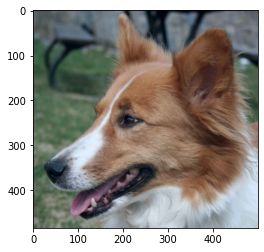

In [20]:
img_dog = Image.open('dog.jpg')
plt.imshow(np.asarray(img_dog))

224 224 0 0 224


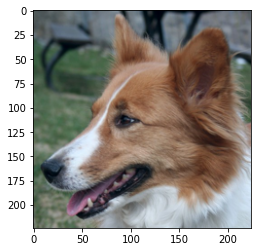

In [23]:
w, h = img_dog.size
s = min(w, h)
y = (h - s) // 2
x = (w - s) // 2
print(w, h, x, y, s)
img_dog = img_dog.crop((x, y, x+s, y+s))
plt.imshow(np.asarray(img_dog))

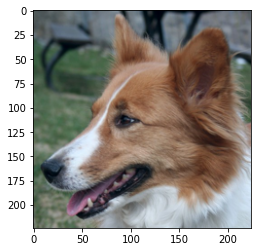

In [24]:
target_size = 224
img_dog = img_dog.resize((target_size, target_size))
plt.imshow(np.asarray(img_dog))

In [25]:
np_img = image.img_to_array(img_dog)
img_batch = np.expand_dims(np_img, axis=0)
pre_processed = preprocess_input(img_batch)
dog_y_preds = model.predict(pre_processed)

In [26]:
np.max(dog_y_preds)

0.61950076

In [27]:
decode_predictions(dog_y_preds, top=5)

[[('n02106030', 'collie', 0.61950076),
  ('n02105855', 'Shetland_sheepdog', 0.26956773),
  ('n02113023', 'Pembroke', 0.05829628),
  ('n02106166', 'Border_collie', 0.02727197),
  ('n02113186', 'Cardigan', 0.014115317)]]

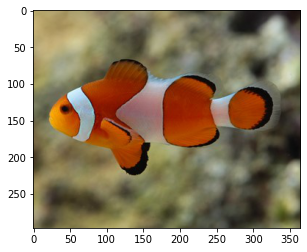

In [28]:
img_nemo = Image.open('nemo.jpg')
plt.imshow(np.asarray(img_nemo))

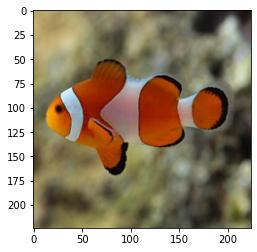

In [32]:
# target_size = 224
# img_nemo = img_nemo.resize((target_size, target_size))
# plt.imshow(np.asarray(img_nemo))

365 297 34 0 297


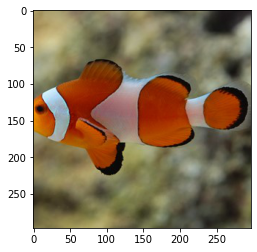

In [29]:
w, h = img_nemo.size
s = min(w, h)
y = (h - s) // 2
x = (w - s) // 2
print(w, h, x, y, s)
img_nemo = img_nemo.crop((x, y, x+s, y+s))
plt.imshow(np.asarray(img_nemo))

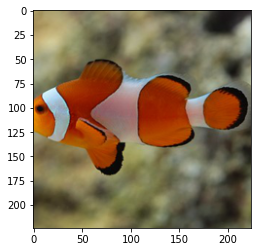

In [30]:
target_size = 224
img_nemo = img_nemo.resize((target_size, target_size))
plt.imshow(np.asarray(img_nemo))

In [31]:
np_img = image.img_to_array(img_nemo)
img_batch = np.expand_dims(np_img, axis=0)
pre_processed = preprocess_input(img_batch)
nemo_y_preds = model.predict(pre_processed)

In [32]:
decode_predictions(nemo_y_preds, top=5)

[[('n02607072', 'anemone_fish', 0.9893456),
  ('n01950731', 'sea_slug', 0.006211043),
  ('n09256479', 'coral_reef', 0.0020690814),
  ('n01914609', 'sea_anemone', 0.0016063297),
  ('n01924916', 'flatworm', 0.0006056085)]]